In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [25]:
path_to_save = "/content/gdrive/MyDrive/VAE_output"

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Input, Dense, Lambda
from keras.layers import Flatten, Reshape
from keras.layers import BatchNormalization, Dropout

# Normalizing the training set

In [75]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

for i in range(32):
  x_train = np.insert(x_train, len(x_train)-1, x_test[i], axis = 0)

x_train = x_train / 255
x_test = x_test / 255

In [76]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

In [77]:
print(x_train.shape)

(60032, 28, 28, 1)


# VAE components and methods

In [84]:
batch_size = 128
hidden_dim = 2 # Since we are in 2D space (images), the dimensions of mean and var are 2
n_epochs = 20

def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def pure_noise(args):
    mean, log_var, batch_size, hidden_dim = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(log_var / 2) * N + mean

In [85]:
class VAE:
  def __init__(self, batch_size_, hidden_dim_, epochs_):
    self.batch_size = batch_size_
    self.hidden_dim = hidden_dim_
    self.epochs = epochs_
    self.input_image = Input(batch_shape=(self.batch_size, 28, 28, 1))
    self.encoder = self.build_the_encoder()
    self.decoder = self.build_the_decoder()

  def build_the_encoder(self):
    x = Flatten()(self.input_image)
    x = Dense(256, activation="relu")(x)
    x = dropout_and_batchnorm(x)
    x = Dense(128, activation="relu")(x)
    x = dropout_and_batchnorm(x)
    # Our prior distribution is N(mean_of_batch, var_of_batch)
    self.mean = Dense(self.hidden_dim)(x)
    self.log_var = Dense(self.hidden_dim)(x)
    # print(K.eval(self.mean))
    # The latent space
    latent_space = Lambda(pure_noise, output_shape=(self.hidden_dim))([self.mean, self.log_var, self.batch_size, self.hidden_dim])
    # The encoder built based on the latent space
    encoder = keras.Model(self.input_image, latent_space)
    return encoder

  def build_the_decoder(self):
    input_decoder = Input(shape=(self.hidden_dim,))
    d = Dense(128, activation="relu")(input_decoder)
    d = dropout_and_batchnorm(d)
    d = Dense(256, activation="relu")(d)
    d = dropout_and_batchnorm(d)
    d = Dense(28*28, activation="sigmoid")(d)
    # The final layer
    decoded_image = Reshape((28, 28, 1))(d)
    decoder = keras.Model(input_decoder, decoded_image)
    return decoder

  def loss(self, main, reconstructed):
    main = K.reshape(main, shape=(self.batch_size, 28*28))
    reconstructed = K.reshape(reconstructed, shape=(self.batch_size, 28*28))
    reconstruction_loss = K.sum(K.square(main-reconstructed), axis=-1)
    kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)
    return reconstruction_loss + kl_loss

In [86]:
vae = VAE(batch_size, hidden_dim, n_epochs)

In [87]:
print(batch_size)

128


In [88]:
model = keras.Model(vae.input_image, vae.decoder(vae.encoder(vae.input_image)))
model.compile(optimizer="adam", loss=vae.loss)

# Training the model

In [89]:
import time
start_time = time.time()
model.fit(x_train, x_train, epochs=vae.epochs, batch_size = vae.batch_size, shuffle=True)
end_time = time.time()
exe_time = end_time - start_time

Train on 60032 samples
Epoch 1/20
60032/60032 [==============================] - 7s 113us/sample - loss: 83.0510
Epoch 2/20
60032/60032 [==============================] - 4s 67us/sample - loss: 50.2017
Epoch 3/20
60032/60032 [==============================] - 6s 92us/sample - loss: 46.9419
Epoch 4/20
60032/60032 [==============================] - 4s 73us/sample - loss: 45.3972
Epoch 5/20
60032/60032 [==============================] - 4s 65us/sample - loss: 44.4021
Epoch 6/20
60032/60032 [==============================] - 4s 75us/sample - loss: 43.8214
Epoch 7/20
60032/60032 [==============================] - 5s 90us/sample - loss: 43.2202
Epoch 8/20
60032/60032 [==============================] - 5s 85us/sample - loss: 42.9104
Epoch 9/20
60032/60032 [==============================] - 4s 75us/sample - loss: 42.6165
Epoch 10/20
60032/60032 [==============================] - 5s 92us/sample - loss: 42.3247
Epoch 11/20
60032/60032 [==============================] - 5s 75us/sample - loss: 42.

In [91]:
print("Exec Time: ", exe_time)

Exec Time:  98.58432459831238


# Sampling from the latent

In [186]:
def sample_from(number_of_samples, interval, seed):
  random.seed(seed)
  points = [random.randrange(interval[0], interval[1]) for _ in range(2*number_of_samples)]
  samples = []
  for i in range(0, 2*number_of_samples, 2):
    samples.append([points[i], points[i+1]])
  return samples

In [248]:
def plot_distribution(vae, points, save, show, series):
  n =  2
  size = 2*n
  num = 1
  plt.figure(figsize=(size, size))
  start = time.time()
  for i in range(-n, n+1):
      for j in range(-n, n+1):
          if(num > len(points)): continue
          image = vae.decoder.predict(np.expand_dims(points[num-1], axis=0))
          if save:
              plt.figure(figsize=(size/2, size/2))
              image_name = path_to_save + '/'+str(vae.epochs)+"_"+str(vae.batch_size)+"_label_"+str(num - 1)+"_"+ str(series) +".png"
              plt.imshow(image.squeeze(), cmap="gray")
              plt.savefig(image_name)

          if show:
            ax = plt.subplot(size, size, num)
            plt.imshow(image.squeeze(), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
          num += 1
  end = time.time()
  exe_time = end - start
  if save == False and show == False:
    return exe_time

In [217]:
import random
number_of_samples = 16
infinity_interval = [-1e6, 1e6]
bad_samples = sample_from(number_of_samples, infinity_interval, seed = 0)

<ipython-input-186-8b0c3cea4973>:3: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  points = [random.randrange(interval[0], interval[1]) for _ in range(2*number_of_samples)]


# Generating Samples

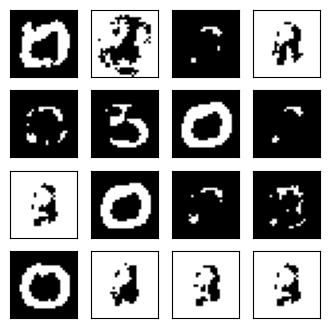

In [218]:
plot_distribution(vae, bad_samples, False, True, series = 0)

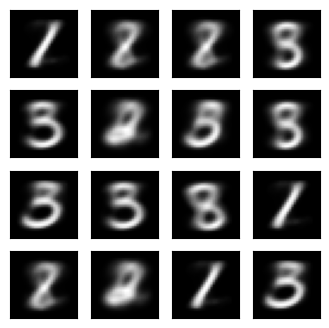

In [219]:
good_interval = [0, 3]
better_samples = sample_from(number_of_samples, good_interval, seed = 1)
plot_distribution(vae, better_samples, False, True, series = 1)

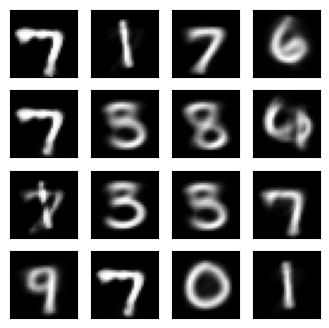

In [220]:
samples = sample_from(number_of_samples, [-4, 4], seed = 2)
plot_distribution(vae, samples, False, True, series = 2)

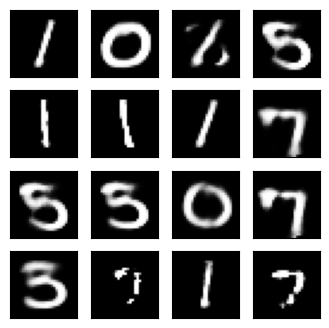

In [221]:
samples = sample_from(number_of_samples, [-10, 10], seed = 3)
plot_distribution(vae, samples, False, True, series = 3)

# Inference Time

In [246]:
def plot_inference_exe_time(inference_exe_time):
  plt.title("Inference execution times")
  plt.scatter(np.arange(0,len(inference_exe_time)), inference_exe_time)

In [242]:
inference_times = []
number_of_runs = 50

In [252]:
temp_inference_times = []

In [253]:
seed = 10
ser = 10
for i in range(number_of_runs):
  thresh = 1e6
  samples = sample_from(number_of_samples, [-thresh, thresh], seed)
  inf_time = plot_distribution(vae, samples, False, False, series = ser)
  seed += 1
  ser += 1
  temp_inference_times.append(inf_time)

<ipython-input-186-8b0c3cea4973>:3: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  points = [random.randrange(interval[0], interval[1]) for _ in range(2*number_of_samples)]
<ipython-input-248-28e212341c32>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(size, size))


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

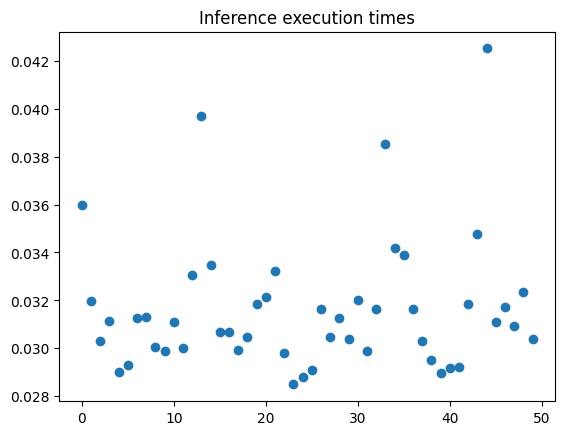

In [247]:
plot_inference_exe_time(inference_times)

In [249]:
print("Mean inference time: ", round(sum(inference_times)/len(inference_times), 4))

Mean inference time:  0.0316


# The whole distribution of latent space (containing all labels)

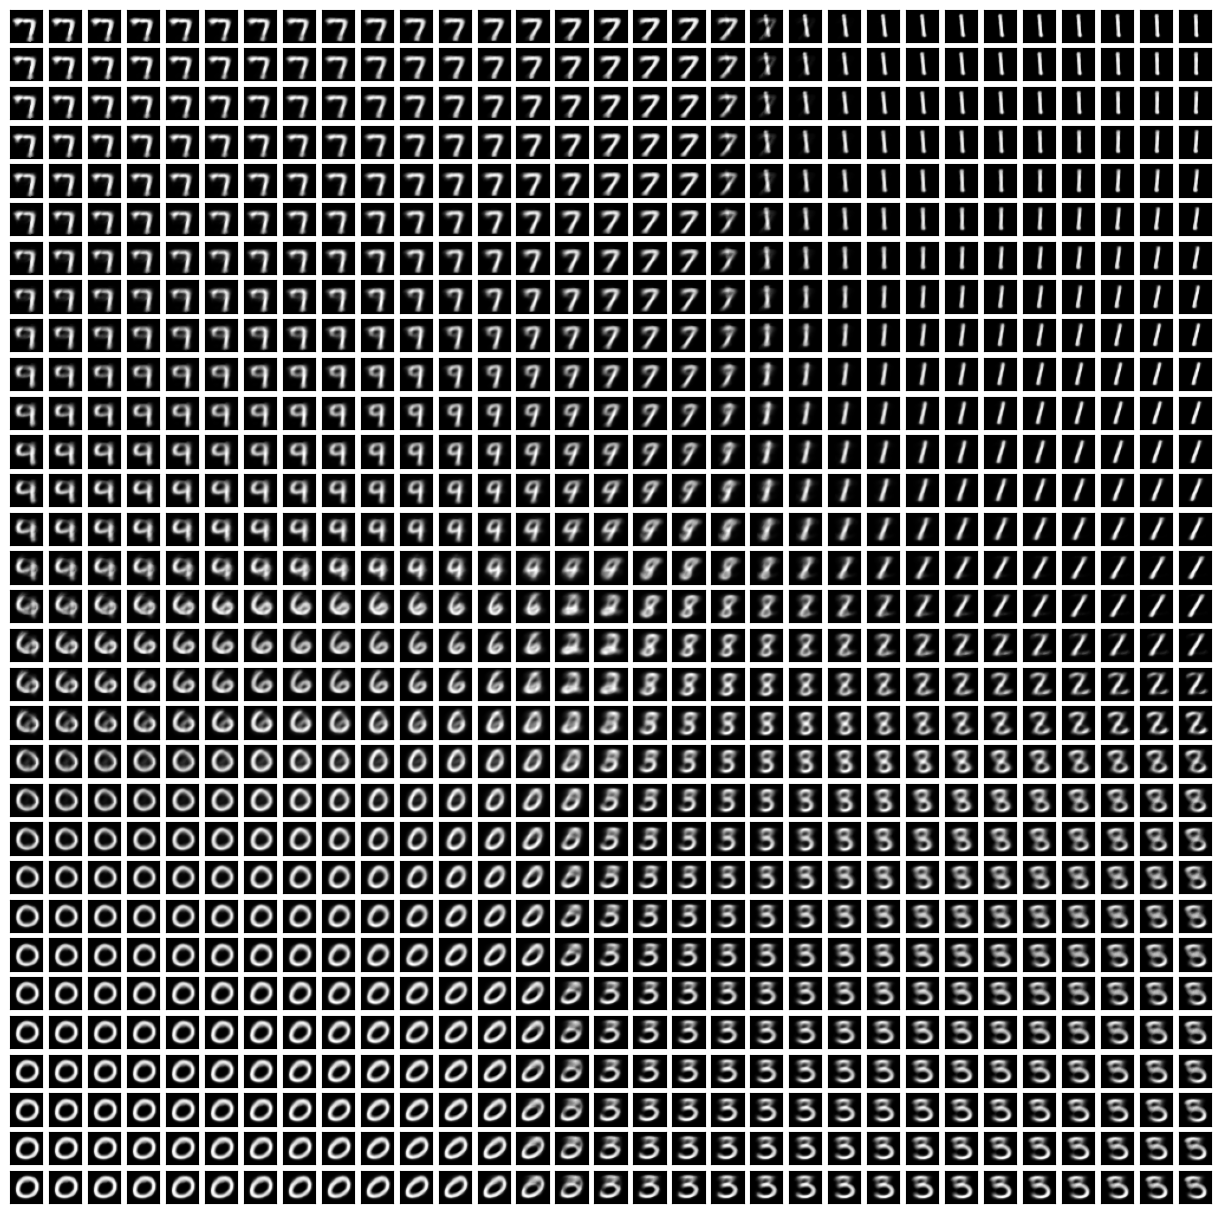

In [222]:
n =  15
size = 2*n+1

num = 1
plt.figure(figsize=(size/2, size/2))
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(size, size, num)
        num += 1
        image = vae.decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0))
        plt.imshow(image.squeeze(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)